# Modeling the Data #
We will start modeling the data to find the best statistical model to work with for our problem

Here are the imports to start things off with

In [1]:
# BASIC & PANDAS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# SKLEARN & MODELING
from sklearn.preprocessing import LabelEncoder

from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

import gc; gc.enable()

import warnings
warnings.filterwarnings("ignore")

# From https://contrib.scikit-learn.org/categorical-encoding/
import category_encoders as ce

from sklearn.metrics import roc_auc_score, confusion_matrix
from sklearn.metrics import plot_confusion_matrix # New to version 0.22.2

## Loading the Dataset ##
Since our dataset came in with a custom ID which got a little messed up during transition so let's clean that up

In [2]:
#Turning on the option to see all columns in the dataset
pd.options.display.max_columns = None 

In [3]:
#Loading in the dataset, renaming the index column and then setting said column as index
df = pd.read_csv("../CSVs/Model_Ready_Data.csv")
df.rename(columns={"Unnamed: 0":"ID"},inplace=True)
df.set_index("ID",inplace=True)
df

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,SK_ID_CURR,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,AMT_APPLICATION,AMT_OLD_ANNUITY,AMT_OLD_CREDIT,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,1,0,202500.0,406597.5,24700.5,351000.0,6,7,4,3,1,0.018801,-9461,-637,-3648.0,-2120,100002,1,1,0,1,1,0,8,1.0,2,2,6,10,0,0,0,0,0,0,5,179055.0,9251.775,179055.0,24.0,18.0
1,0,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,1,4,1,1,1,0.003541,-16765,-1188,-1186.0,-291,100003,1,1,0,1,1,0,3,2.0,1,1,1,11,0,0,0,0,0,0,39,900000.0,98356.995,1035882.0,12.0,1.0
2,0,1,1,1,1,0,67500.0,135000.0,6750.0,135000.0,6,7,4,3,1,0.010032,-19046,-225,-4260.0,-2531,100004,1,1,1,1,1,0,8,1.0,2,2,1,9,0,0,0,0,0,0,11,24282.0,5357.250,20106.0,4.0,2.0
3,0,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,6,7,4,0,1,0.008019,-19005,-3039,-9833.0,-2437,100006,1,1,0,1,0,0,8,2.0,2,2,6,17,0,0,0,0,0,0,5,675000.0,24246.000,675000.0,5.0,0.0
4,0,0,1,0,1,0,121500.0,513000.0,21865.5,513000.0,6,7,4,3,1,0.028663,-19932,-3038,-4311.0,-3458,100007,1,1,0,1,0,0,3,1.0,2,2,4,11,0,0,0,0,1,1,37,180000.0,16509.600,180000.0,24.0,15.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,0,1,0,0,0,157500.0,254700.0,27558.0,225000.0,6,7,4,2,5,0.032561,-9327,-236,-8456.0,-1982,456251,1,1,0,1,0,0,14,1.0,1,1,4,15,0,0,0,0,0,0,43,40455.0,6605.910,40455.0,12.0,7.0
307507,0,0,0,0,1,0,72000.0,269550.0,12001.5,225000.0,6,3,4,5,1,0.025164,-20775,365243,-4388.0,-4090,456252,1,0,0,1,1,0,8,1.0,2,2,1,8,0,0,0,0,0,0,57,57595.5,10074.465,56821.5,6.0,0.0
307508,0,0,0,0,1,0,153000.0,677664.0,29979.0,585000.0,6,7,1,2,1,0.005002,-14966,-7921,-6737.0,-5150,456253,1,1,0,1,0,1,10,1.0,3,3,4,9,0,0,0,0,1,1,39,28912.5,5567.715,27306.0,6.0,2.0


### Modeling Setup ###
#### Baseline: Random Forest Classifier ####
First I need to scale my numerical columns so I need to split them out from the categorical columns

In [4]:
cat_col = df[['NAME_CONTRACT_TYPE','CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_TYPE_SUITE',
               'NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS','NAME_HOUSING_TYPE',
               'OCCUPATION_TYPE','WEEKDAY_APPR_PROCESS_START','ORGANIZATION_TYPE']]

num_col = df.drop(columns=cat_col)
num_col1 = num_col.drop(columns=['TARGET','DAYS_BIRTH'])

In [5]:
cat_cols = list(cat_col)
num_cols = list(num_col1)
X_cols = cat_cols + num_cols

scaler = MinMaxScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

Now that the data is scaled it is ready for the baseline setup

In [6]:
#Setting up the target value as y
X = df[X_cols]
y = df['TARGET']

#Setting up the train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.4, random_state=42)

In [7]:
#Fitting the pipeline data to the training set
rfc = RandomForestClassifier()
pipe = make_pipeline(rfc)

#Fitting the data to a pipeline and setting up the preds
pipe.fit(X_train, y_train)

train_preds = pipe.predict(X_train)
test_preds = pipe.predict(X_test)

In [8]:
#The first metric to aim for is going to be ROC_AUC
train_score = roc_auc_score(y_train, train_preds)
test_score = roc_auc_score(y_test, test_preds)

print(f'train score: {train_score}')
print(f'test score: {test_score}')

train score: 0.9997162718116045
test score: 0.5000530560271647


It looks like the test score is only right half the time so let's do some more fiddling with the data

In [9]:
#Setup some grid parameters
grid_param = {'n_estimators': [50,100],
              'class_weight': ['balanced'],
              'criterion': ['gini','entropy'],
              'max_depth': [2,4,6]
             }

In [10]:
#Fit the parameters onto our data
grid_search = GridSearchCV(rfc, grid_param, cv=3, scoring='roc_auc')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [11]:
#Applying better parameters to see if our score will improve at all or not.
rfc_grid = grid_search.best_estimator_
rfc_grid.fit(X_train, y_train)

train_pred2 = rfc_grid.predict_proba(X_train)[:,1]
test_pred2 = rfc_grid.predict_proba(X_test)[:,1]

train_score2 = roc_auc_score(y_train, train_pred2)
test_score2 = roc_auc_score(y_test, test_pred2)

print(f'Train Score #2: {train_score2}')
print(f'Test Score #2: {test_score2}')

Train Score #2: 0.6820047324428788
Test Score #2: 0.6577481554558843


The Test score went up a little bit and the train and test are closer now so we're going in the right step

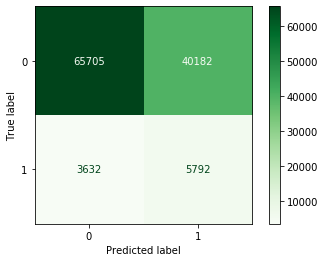

In [12]:
#See how well our model did in predicting the values
plot_confusion_matrix(rfc_grid, X_test, y_test, cmap=plt.cm.Greens, values_format='.6g')
plt.grid(False)

Let's Try out a Different approach.

I want to bin the data to work with a more targeted portion so let's see how our data is divided with age

In [13]:
#Make a new column with the dates converted into years
df['YEARS_BIRTH'] = abs(df['DAYS_BIRTH']) / 365

#Figuring out the range of ages we are working with
print(df['YEARS_BIRTH'].min())
print(df['YEARS_BIRTH'].max())

20.517808219178082
69.04383561643836


In [14]:
#Bin the years
df['YEARS_BIN'] = pd.cut(df['YEARS_BIRTH'], bins = np.linspace(20, 70, num = 6))

#Making a dataframe with the information in question and seeing what our results are
df_dob = df[['TARGET','YEARS_BIRTH','YEARS_BIN']]
df_dob_check = df_dob.groupby('YEARS_BIN').mean()
df_dob_check

,TARGET,YEARS_BIRTH
YEARS_BIN,,
"(20.0, 30.0]",0.117354,26.632140
"(30.0, 40.0]",0.097489,35.126556
"(40.0, 50.0]",0.076842,44.753022
"(50.0, 60.0]",0.061498,54.984934
"(60.0, 70.0]",0.048950,63.361619


With the analysis we can see that the biggest chunk of our target (So the individuals that defaulted on their home loans) lies in the age ranges of 20-30.

Let's try out some models only using this segment of the data

In [15]:
#Scaling the data again with the columns setup earlier
df[num_cols] = scaler.fit_transform(df[num_cols])

In [16]:
#Since the new column will be categorical I need to encode it.
#Time to apply the above fixes to the main dataframe
le = LabelEncoder()
df['YEARS_BIN'] = le.fit_transform(df['YEARS_BIN'])

In [17]:
#Now to filter out only the 20-30s and then getting rid of the other two columns 
df_20to30 = df.loc[df['YEARS_BIN']<1]
df_2 = df_20to30.drop(columns=['DAYS_BIRTH','YEARS_BIRTH'])
df_2

,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,SK_ID_CURR,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,AMT_APPLICATION,AMT_OLD_ANNUITY,AMT_OLD_CREDIT,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,YEARS_BIN
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0,1,0,1,0.000000,0.001512,0.092450,0.103342,0.082045,6,7,4,3,1,0.256321,0.045086,0.852140,0.705433,0.000000,0.0,1.0,0.0,1.0,1.0,0.0,8,0.000000,0.5,0.5,6,0.434783,0.0,0.0,0.0,0.0,0.0,0.0,5,0.030608,0.031863,0.043626,0.323944,0.250000,0
10,0,0,0,0,1,0.052632,0.000742,0.155320,0.087569,0.161712,6,7,1,1,1,0.311695,0.044977,0.820566,0.897457,0.000034,0.0,1.0,0.0,1.0,0.0,0.0,3,0.105263,0.5,0.5,2,0.652174,0.0,0.0,0.0,0.0,0.0,0.0,30,0.012615,0.048373,0.017981,0.154930,0.138889,0
15,0,0,1,1,1,0.000000,0.001127,0.065138,0.083016,0.054697,1,7,4,3,4,0.282797,0.043729,0.858382,0.809921,0.000048,0.0,1.0,0.0,1.0,0.0,0.0,8,0.000000,1.0,1.0,2,0.260870,0.0,0.0,0.0,1.0,1.0,0.0,4,0.014382,0.036226,0.025505,0.154930,0.111111,0
17,0,1,0,0,1,0.052632,0.000473,0.057526,0.053202,0.060642,6,7,4,1,1,0.147830,0.046250,0.832077,0.662776,0.000053,0.0,1.0,0.0,1.0,0.0,0.0,8,0.105263,0.5,0.5,1,0.434783,0.0,0.0,0.0,1.0,1.0,0.0,7,0.004462,0.017193,0.006695,0.154930,0.125000,0
28,0,0,1,1,1,0.000000,0.002089,0.190687,0.250962,0.167658,6,4,1,3,1,0.635991,0.042061,0.810798,0.630263,0.000087,0.0,1.0,0.0,1.0,0.0,1.0,8,0.000000,0.0,0.0,6,0.478261,0.0,1.0,1.0,0.0,0.0,0.0,31,0.009162,0.019090,0.012993,0.154930,0.152778,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307470,0,0,0,0,1,0.000000,0.000550,0.057526,0.038919,0.060642,6,7,4,1,1,0.392880,0.045151,0.810636,0.551063,0.999874,0.0,1.0,1.0,1.0,1.0,0.0,2,0.052632,0.5,0.5,1,0.434783,0.0,0.0,0.0,0.0,1.0,1.0,11,0.011885,0.034161,0.016252,0.154930,0.069444,0
307480,0,0,0,0,0,0.052632,0.000473,0.333651,0.169477,0.346017,6,4,1,1,4,0.336758,0.036688,0.948930,0.695984,0.999902,0.0,1.0,0.0,1.0,0.0,0.0,3,0.105263,0.5,0.5,0,0.478261,0.0,0.0,0.0,0.0,0.0,0.0,11,0.006652,0.019351,0.010262,0.000000,0.000000,0
307488,0,0,0,0,0,0.000000,0.001127,0.023010,0.052537,0.024970,6,4,1,3,1,0.064665,0.043570,0.831469,0.613311,0.999935,0.0,1.0,0.0,1.0,0.0,0.0,3,0.000000,0.5,0.5,6,0.782609,0.0,0.0,0.0,0.0,1.0,1.0,11,0.010762,0.041265,0.015339,0.154930,0.152778,0


In [18]:
#Setting up the target value as y
X2 = df_2.drop(columns='TARGET')
y2 = df_2['TARGET']

#Setting up the train/test split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=.4, random_state=42)

In [19]:
#Doing another Random Forest on this new dataset to see what kind of results I get
rfc_grid.fit(X_train2, y_train2)

train_pred3 = rfc_grid.predict_proba(X_train2)[:,1]
test_pred3 = rfc_grid.predict_proba(X_test2)[:,1]

train_score3 = roc_auc_score(y_train2, train_pred3)
test_score3 = roc_auc_score(y_test2, test_pred3)

print(f'Train Score #3: {train_score3}')
print(f'Test Score #3: {test_score3}')

Train Score #3: 0.7214990131407252
Test Score #3: 0.639231832377972


Sadly Focusing our dataset down didn't produce any better results for our test score. Let's try out a new model

In [20]:
#Fitting the pipeline data to the training set
lr = LogisticRegression()
pipe4 = make_pipeline(lr)

#Fitting the data to a pipeline and setting up the preds
pipe4.fit(X_train2, y_train2)

train_preds4 = pipe4.predict(X_train2)
test_preds4 = pipe4.predict(X_test2)

train_score4 = roc_auc_score(y_train2, train_preds4)
test_score4 = roc_auc_score(y_test2, test_preds4)

print(f'Train Score #4: {train_score3}')
print(f'Test Score #4: {test_score3}')

Train Score #4: 0.7214990131407252
Test Score #4: 0.639231832377972


Looks like the best score I got was with the Random Forest with the best parameters added in

Finally for my presentation I want to look at what the biggest factors (feature importance) are so let's do a quick analysis on that

Feature ranking:
1. feature 20 (0.064023)
2. feature 19 (0.062552)
3. feature 21 (0.060514)
4. feature 15 (0.057357)
5. feature 18 (0.056549)
6. feature 39 (0.052308)
7. feature 14 (0.051227)
8. feature 40 (0.049537)
9. feature 38 (0.046692)
10. feature 13 (0.045987)
11. feature 17 (0.045128)
12. feature 42 (0.043393)
13. feature 16 (0.042000)
14. feature 31 (0.039618)
15. feature 11 (0.033823)
16. feature 41 (0.033353)
17. feature 10 (0.027156)
18. feature 9 (0.025073)
19. feature 7 (0.017390)
20. feature 28 (0.016193)
21. feature 12 (0.011812)
22. feature 4 (0.010476)
23. feature 8 (0.009998)
24. feature 6 (0.009169)
25. feature 5 (0.008584)
26. feature 3 (0.008496)
27. feature 2 (0.007719)
28. feature 26 (0.007635)
29. feature 24 (0.007284)
30. feature 1 (0.006612)
31. feature 30 (0.006146)
32. feature 29 (0.006091)
33. feature 36 (0.005308)
34. feature 37 (0.005009)
35. feature 35 (0.004446)
36. feature 27 (0.004213)
37. feature 0 (0.002917)
38. feature 33 (0.002735)
39. feature 34

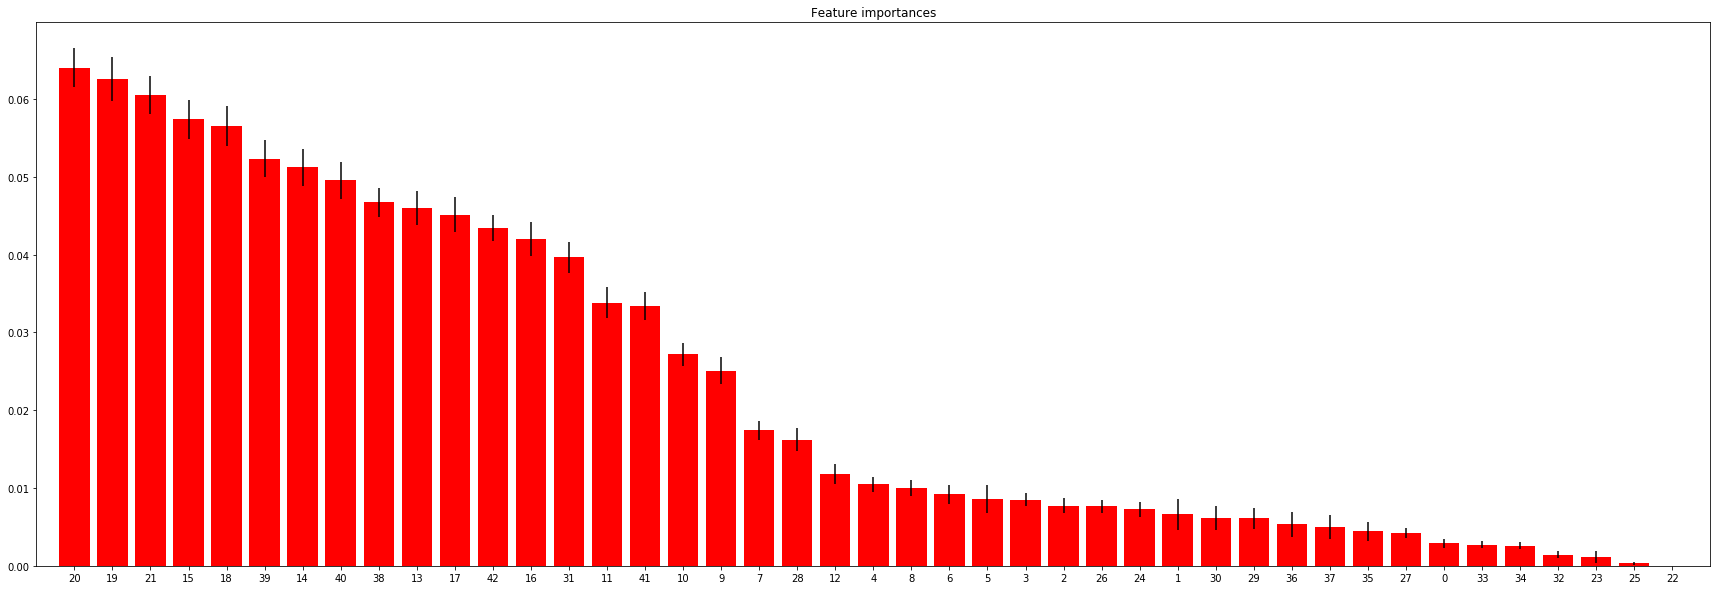

In [21]:
# Build a forest and compute the feature importances
rfc_grid.fit(X_train2, y_train2)
importances = rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfc.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(30,10))
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [22]:
df_mostimp = df_2[df_2.columns[[20,19,21,15,18,39,40,14,38,13]]]
df_leastimp = df_2[df_2.columns[[36,37,35,27,33,34,32,23,25,22]]]
df_most_imp = df_mostimp.join(df_2['TARGET'])
df_least_imp = df_leastimp.join(df_2['TARGET'])

In [23]:
df_most_imp.loc[df_most_imp['TARGET']>=1]

,DAYS_ID_PUBLISH,FLAG_EMP_PHONE,FLAG_MOBIL,FLAG_WORK_PHONE,REGION_POPULATION_RELATIVE,SK_ID_CURR,AMT_OLD_ANNUITY,NAME_HOUSING_TYPE,AMT_OLD_CREDIT,AMT_APPLICATION,TARGET
ID,,,,,,,,,,,
0,0.705433,1.0,0.0,0.0,0.256321,0.000000,0.031863,1,0.043626,0.030608,1
94,0.855773,1.0,0.0,0.0,0.421848,0.000309,0.071373,5,0.026562,0.020707,1
110,0.556760,1.0,0.0,0.0,0.096707,0.000359,0.038731,1,0.024124,0.016925,1
184,0.953175,1.0,0.0,0.0,0.446855,0.000595,0.015014,1,0.008859,0.006284,1
261,0.997777,1.0,0.0,0.0,0.309272,0.000839,0.044340,1,0.060058,0.031784,1
...,...,...,...,...,...,...,...,...,...,...,...
307268,0.845213,1.0,0.0,0.0,0.344429,0.999242,0.072063,5,0.104158,0.073077,1
307377,0.548006,1.0,0.0,0.0,0.429796,0.999571,0.027457,1,0.021178,0.011538,1
307433,0.679172,0.0,0.0,0.0,0.429796,0.999764,0.014229,2,0.009539,0.006726,1


In [178]:
df_most_default

,DAYS_REGISTRATION,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,DAYS_ID_PUBLISH,AMT_CREDIT,AMT_OLD_ANNUITY,AMT_APPLICATION,AMT_INCOME_TOTAL,ORGANIZATION_TYPE,NAME_HOUSING_TYPE,CNT_CHILDREN,TARGET
ID,,,,,,,,,,,,
0,-3648.0,-637,0.018801,-2120,406597.5,9251.775,179055.00,202500.0,5,1,0,1
94,-4802.0,-2015,0.030755,-1038,953460.0,20723.580,121135.50,315000.0,21,5,0,1
110,-387.0,-267,0.007274,-3190,723996.0,11245.950,99013.50,157500.0,46,1,1,1
184,-1724.0,-111,0.032561,-337,436032.0,4359.555,36760.50,202500.0,5,1,1,1
261,-3062.0,-166,0.022625,-16,571486.5,12874.590,185935.14,112500.0,5,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
307268,-7647.0,-425,0.025164,-1114,355536.0,20924.100,427500.00,135000.0,7,5,0,1
307377,-7404.0,-235,0.031329,-3253,313438.5,7972.470,67500.00,67500.0,3,1,0,1
307433,-4074.0,365243,0.031329,-2309,113760.0,4131.495,39348.00,50400.0,57,2,0,1


In [24]:
df_least_imp.loc[df_least_imp['TARGET']>=1]

,ORGANIZATION_TYPE,REG_CITY_NOT_WORK_CITY,REGION_RATING_CLIENT,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_REGION_NOT_WORK_REGION,FLAG_PHONE,OCCUPATION_TYPE,FLAG_CONT_MOBILE,LIVE_CITY_NOT_WORK_CITY,TARGET
ID,,,,,,,,,,,
0,5,0.0,0.5,0.0,0.0,0.0,1.0,8,1.0,0.0,1
94,21,1.0,0.5,0.0,0.0,0.0,0.0,8,1.0,1.0,1
110,46,1.0,0.5,1.0,0.0,1.0,1.0,14,1.0,1.0,1
184,5,0.0,0.0,0.0,0.0,0.0,1.0,8,1.0,0.0,1
261,5,0.0,0.5,0.0,0.0,0.0,0.0,8,1.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...
307268,7,0.0,0.5,0.0,0.0,0.0,0.0,8,1.0,0.0,1
307377,3,1.0,0.5,0.0,0.0,0.0,0.0,8,1.0,1.0,1
307433,57,0.0,0.5,0.0,0.0,0.0,0.0,8,1.0,0.0,1


Conclusion for Project Presentation:

The 5 Most important features for the age range of 20-30 is as follows:

* 1. How many days before the application the person started current employment
    * Majority of the individuals were only employed for a short amount of time
* 2. The population density of the individual's home address
    * Most of the individuals lived in low density areas so outside of cities or other crowded residential areas
* 3. The amount of the loan
    * This amount flucuated a lot but it was most of the time 3 times higher than the income of the individual
* 4. If the household had a child or not
    * Most of the individuals that defaulted had 0 or only 1 child
* 5. Occupation Type
    * The data shows most individuals that defaulted were ones that were in lower paying jobs designated "laborer"
    
The 5 Least important features is:

* 1. The number of payments left on the loan
    * The rate at which the individual defaulted on the loans wasn't dependant on how much longer they had left to pay off the loan
* 2. The Size of the family
    * The number of family members living under the same household didn't affect the risk much
* 3. The region rating
    * Value set by the original dataset rating the quality of the living establishment
* 4. If an individual had multiple addresses listed under different categories
    * Many of them had different addresses listed under their work/personal/contact seperately
* 5. If an individual had a phone or not